In [1]:
from coreLib.dataset import DataSet
data_dir       = "/media/ansary/DriveData/Work/bengalAI/datasets/CraftData/source"
ds=DataSet(data_dir)
ds.bangla.graphemes.csv

#LOG     :All paths found
#LOG     :Processing Dictionary:/media/ansary/DriveData/Work/bengalAI/datasets/CraftData/source/bangla/dictionary.csv


  0%|          | 0/1059977 [00:00<?, ?it/s]

#LOG     :converting int labels to string


  0%|          | 0/10305 [00:00<?, ?it/s]

#LOG     :Processing Dictionary:/media/ansary/DriveData/Work/bengalAI/datasets/CraftData/source/english/dictionary.csv


  0%|          | 0/370098 [00:00<?, ?it/s]

#LOG     :bangla.graphemes


  0%|          | 0/200840 [00:00<?, ?it/s]

#LOG     :bangla.numbers


  0%|          | 0/72045 [00:00<?, ?it/s]

#LOG     :english.graphemes


  0%|          | 0/46101 [00:00<?, ?it/s]

#LOG     :english.numbers


  0%|          | 0/10305 [00:00<?, ?it/s]

#LOG     :common.symbols


  0%|          | 0/5975 [00:00<?, ?it/s]

#LOG     :bangla.fonts


  0%|          | 0/21 [00:00<?, ?it/s]

#LOG     :english.fonts


  0%|          | 0/2682 [00:00<?, ?it/s]

#LOG     :common.background


  0%|          | 0/982 [00:00<?, ?it/s]

#LOG     :common.noise.random


  0%|          | 0/112763 [00:00<?, ?it/s]

#LOG     :common.noise.sign


  0%|          | 0/3240 [00:00<?, ?it/s]

'/media/ansary/DriveData/Work/bengalAI/datasets/CraftData/source/bangla/graphemes.csv'

bangla handwritten grapheme True


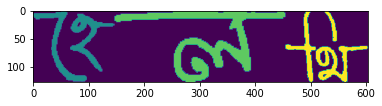

{2: 'হে', 3: 'ল', 4: 'থি'}
bangla handwritten grapheme False


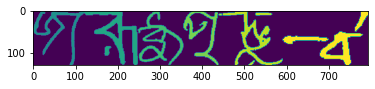

{5: 'জ্য', 6: 'রূ', 7: 'ধ্যু', 8: 'পৃ', 9: 'দ্ভু', 10: 'র্ব'}
bangla handwritten number True


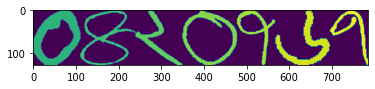

{11: '০', 12: '৪', 13: '২', 14: '০', 15: '৭', 16: '৬', 17: '৭'}
bangla handwritten number False


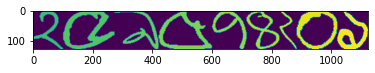

{18: '২', 19: '৫', 20: '৯', 21: '৫', 22: '৭', 23: '৪', 24: '২', 25: '০', 26: '১'}
bangla printed grapheme True


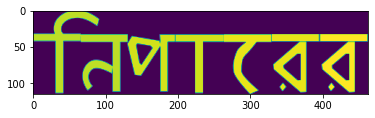

{27: 'নি', 28: 'পা', 29: 'রে', 30: 'র'}
bangla printed grapheme False


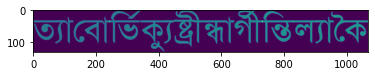

{31: 'ত্যা', 32: 'বো', 33: 'র্ভি', 34: 'ক্যু', 35: 'ষ্ট্রী', 36: 'ন্ধা', 37: 'র্গী', 38: 'ন্তি', 39: 'ল্যা', 40: 'কৈ'}
bangla printed number True


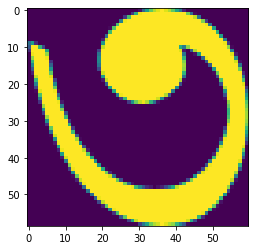

{41: '৩'}
bangla printed number False


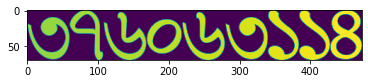

{42: '৩', 43: '৭', 44: '৬', 45: '০', 46: '৬', 47: '৩', 48: '১', 49: '১', 50: '৪'}
english handwritten grapheme True


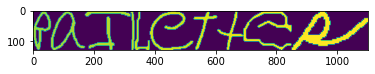

{51: 'p', 52: 'a', 53: 'i', 54: 'l', 55: 'l', 56: 'e', 57: 't', 58: 't', 59: 'e', 60: 's'}
english handwritten grapheme False


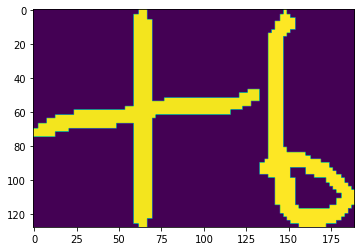

{61: 't', 62: 'b'}
english handwritten number True


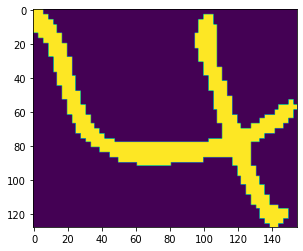

{63: '4'}
english handwritten number False


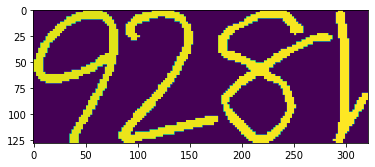

{64: '9', 65: '2', 66: '8', 67: '1'}
english printed grapheme True


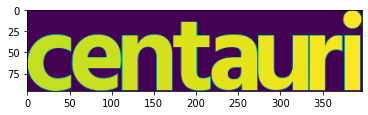

{68: 'c', 69: 'e', 70: 'n', 71: 't', 72: 'a', 73: 'u', 74: 'r', 75: 'i'}
english printed grapheme False


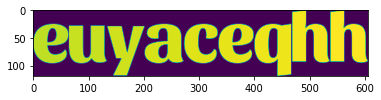

{76: 'e', 77: 'u', 78: 'y', 79: 'a', 80: 'c', 81: 'e', 82: 'q', 83: 'h', 84: 'h'}
english printed number True


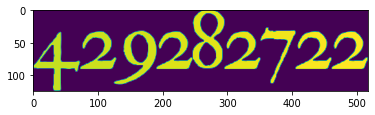

{85: '4', 86: '2', 87: '9', 88: '2', 89: '8', 90: '2', 91: '7', 92: '2', 93: '2'}
english printed number False


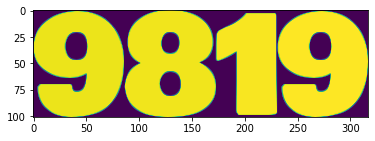

{94: '9', 95: '8', 96: '1', 97: '9'}


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2
import numpy as np
iden=2
from coreLib.word import create_word
'''
source_type             :       bangla/english 
data_type               :       handwritten/printed                  
comp_type               :       grapheme/number
'''
for source in ["bangla","english"]:
    for data in ["handwritten","printed"]:
        for comp in ["grapheme","number"]:
            for ud in [True,False]:
                print("=========================================")
                print(source,data,comp,str(ud))
                img,label,iden=create_word(iden,
                                source,
                                data,
                                comp,
                                ds,
                                use_dict=ud)
                plt.imshow(img)
                plt.show()
                print(label)
                print("=========================================")


In [3]:
ds.english.numbers.dir


'/media/ansary/DriveData/Work/bengalAI/datasets/CraftData/source/english/numbers'